In [51]:
import math

import matplotlib.pyplot as plt

import keras

import pandas as pd

import numpy as np

from keras.models import Sequential

from keras.layers import Dense

from keras.layers import LSTM

from keras.layers import Dropout

from keras.layers import *

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import random

import torch.optim as optim

import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

import datetime
import tensorflow as tf



# 데이터 개요

In [52]:
data = pd.read_csv('MinMaxScaled_Winsorized_Feature_20231102.csv')
# Drop the specified columns from the dataset
data = data.drop(columns=[
    'quote_av',
    'tb_base_av',
    'tb_quote_av',
])

# 'Close' 컬럼을 가져온 후 데이터프레임에서 제거
close_col = data['Close']
data = data.drop('Close', axis=1)

# 'Close' 컬럼을 데이터프레임의 마지막에 추가
data['Close'] = close_col

data.head()


,Open_time,Open,High,Low,Volume,trades,VIX,Bitcoin_TransactionFee,volatility,GoogleTrend,DowJones,EuroStoxx50,Nasdaq,OilWTI,SPX,TradePermin,Dominance,Gold,Close
0,2018-01-03,0.178472,0.183056,0.174321,0.042299,0.019350,0.000000,1.0,1.000000,0.586219,0.347696,0.528794,0.088459,0.464681,0.185866,0.535315,0.130527,0.153586,0.182041
1,2018-01-04,0.182041,0.182636,0.170643,0.058249,0.020318,0.001940,1.0,1.000000,0.574495,0.356069,0.557710,0.089714,0.467958,0.190137,0.590266,0.130527,0.153136,0.184218
2,2018-01-05,0.184219,0.211488,0.181456,0.063900,0.023233,0.001940,1.0,1.000000,0.551046,0.368192,0.576702,0.095660,0.463042,0.197623,0.621124,0.130527,0.156118,0.213774
3,2018-01-06,0.213774,0.210984,0.203833,0.050138,0.018765,0.010254,1.0,0.907375,0.515873,0.367485,0.581025,0.097772,0.465543,0.199405,0.419330,0.130527,0.156118,0.215475
4,2018-01-07,0.215475,0.210328,0.197471,0.032264,0.013878,0.010254,1.0,0.911113,0.480700,0.367485,0.581025,0.097772,0.465543,0.199405,0.426805,0.072534,0.156118,0.201174


In [53]:
data['Open_time']=pd.to_datetime(data['Open_time'])

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Open_time               2067 non-null   datetime64[ns]
 1   Open                    2067 non-null   float64       
 2   High                    2067 non-null   float64       
 3   Low                     2067 non-null   float64       
 4   Volume                  2067 non-null   float64       
 5   trades                  2067 non-null   float64       
 6   VIX                     2067 non-null   float64       
 7   Bitcoin_TransactionFee  2067 non-null   float64       
 8   volatility              2067 non-null   float64       
 9   GoogleTrend             2067 non-null   float64       
 10  DowJones                2067 non-null   float64       
 11  EuroStoxx50             2067 non-null   float64       
 12  Nasdaq                  2067 non-null   float64 

<Axes: xlabel='Open_time'>

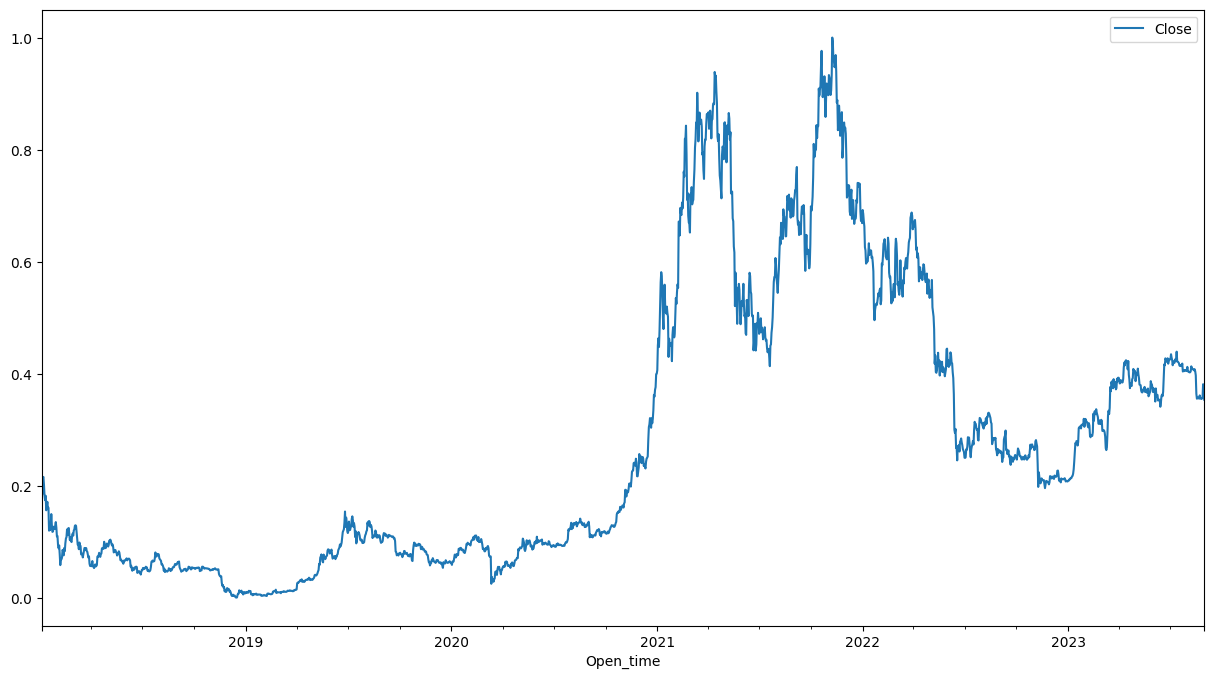

In [55]:
data.plot(x='Open_time',y='Close',figsize=(15,8))

<Axes: >

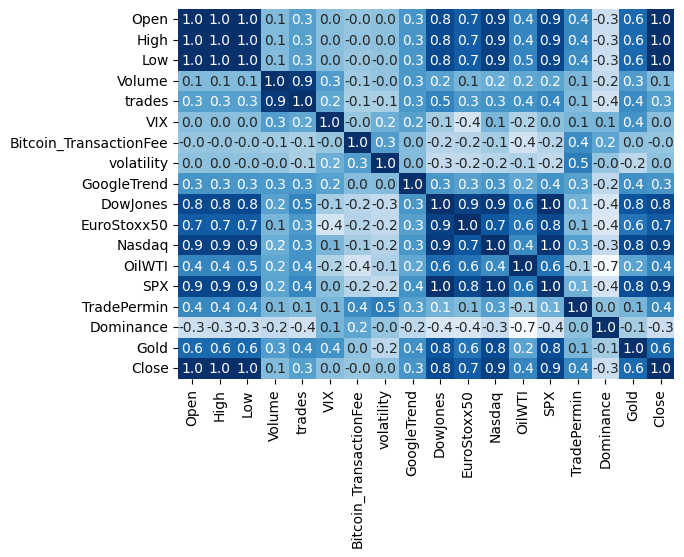

In [56]:
sns.heatmap(data.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

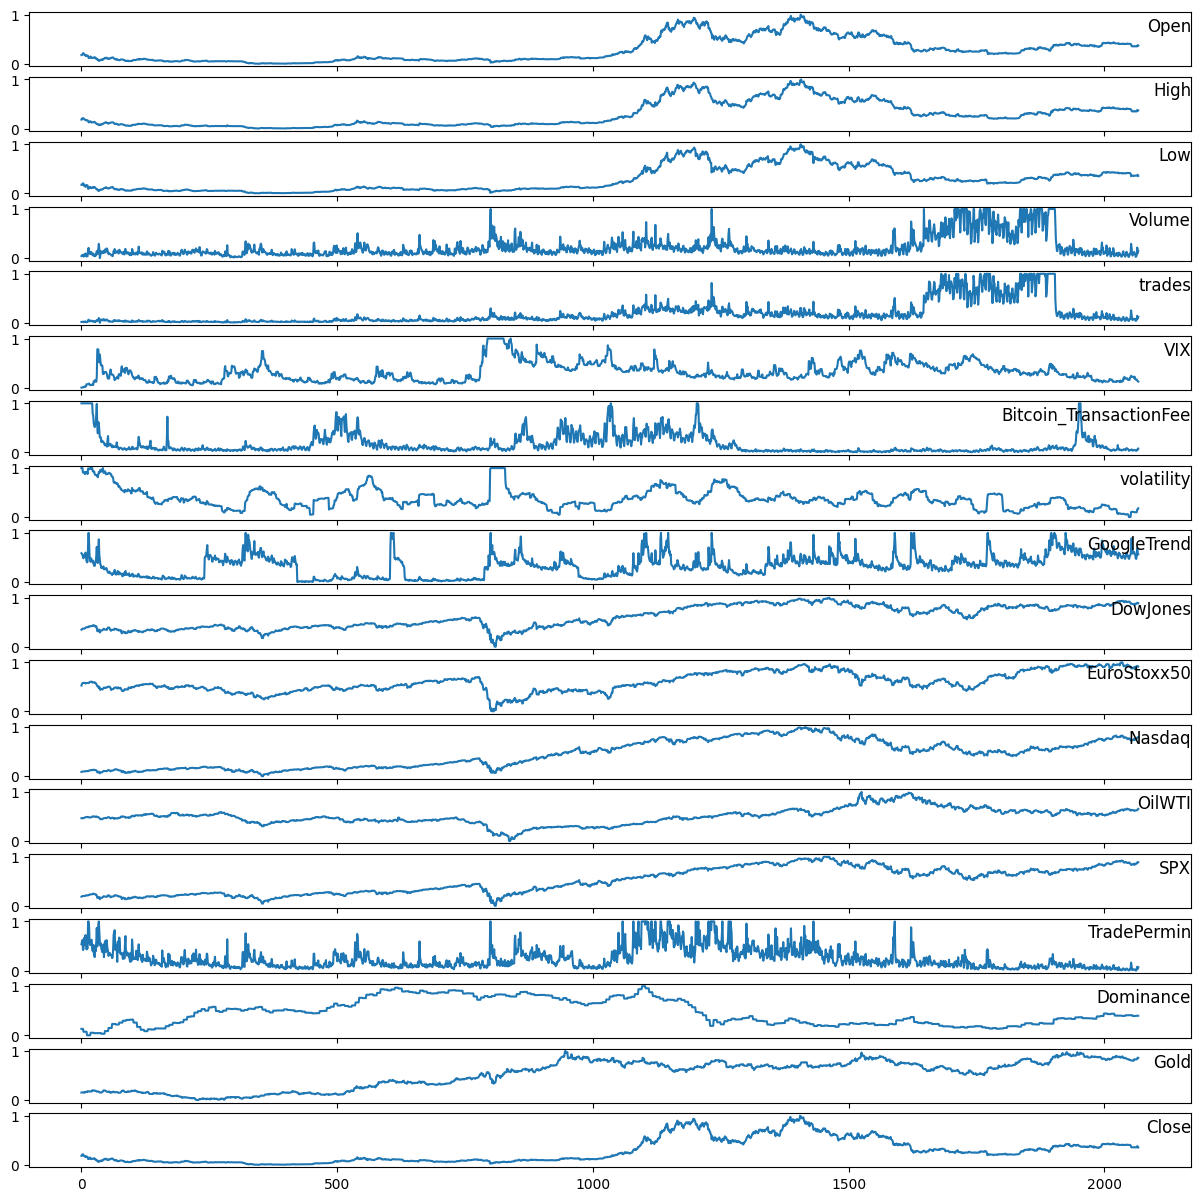

In [57]:
from matplotlib import pyplot
# load dataset
values = data.values
# specify columns to plot
groups = [1, 2, 3,4, 5, 6, 7,8,9,10,11,12,13,14,15,16,17,18]
i = 1
# plot each column
pyplot.figure(figsize=(15,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [58]:
df = data.drop(columns = ['Open_time'])
dfx = df.drop(columns=['Close'])
dfy = df['Close']


In [59]:
dfx.describe()

,Open,High,Low,Volume,trades,VIX,Bitcoin_TransactionFee,volatility,GoogleTrend,DowJones,EuroStoxx50,Nasdaq,OilWTI,SPX,TradePermin,Dominance,Gold
count,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000,2067.000000
mean,0.276965,0.278327,0.273581,0.223307,0.190255,0.320752,0.158204,0.377829,0.330502,0.605078,0.600386,0.454786,0.502943,0.507952,0.245541,0.470539,0.524987
std,0.250640,0.251939,0.247594,0.220089,0.236912,0.192820,0.191858,0.196553,0.220242,0.225127,0.200092,0.277704,0.165071,0.264586,0.217737,0.263188,0.286555
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.076652,0.076508,0.074695,0.094480,0.041661,0.178622,0.041587,0.255089,0.117244,0.400895,0.459845,0.175502,0.404439,0.250682,0.089057,0.238809,0.191927
50%,0.182041,0.185984,0.173426,0.142891,0.103197,0.284076,0.076092,0.348237,0.340007,0.584020,0.558509,0.482506,0.499696,0.498027,0.169408,0.407894,0.631899
75%,0.422018,0.419706,0.421620,0.240848,0.211283,0.425976,0.210298,0.472149,0.463113,0.831363,0.775902,0.710046,0.594349,0.743609,0.335787,0.726421,0.757046
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
dfy.head()

0    0.182041
1    0.184218
2    0.213774
3    0.215475
4    0.201174
Name: Close, dtype: float64

In [61]:
# 두 데이터를 리스트 형태로 저장
X = dfx.values.tolist()
y = dfy.values.tolist()

In [62]:
X[:5]

[[0.1784723445601594,
  0.1830556802361408,
  0.1743208003534068,
  0.0422988388872968,
  0.0193495481797742,
  0.0,
  1.0,
  1.0,
  0.5862192942727646,
  0.3476959223889646,
  0.5287939822331231,
  0.088459448609765,
  0.4646807844015279,
  0.1858656746745025,
  0.5353152573956815,
  0.1305271707052853,
  0.1535864978902952],
 [0.1820409238345986,
  0.1826363477295031,
  0.1706427569532557,
  0.0582489264404679,
  0.0203176046468649,
  0.0019400345495502,
  1.0,
  1.0,
  0.5744949083873092,
  0.3560687444666328,
  0.5577104452603283,
  0.0897144513873964,
  0.4679580729777711,
  0.1901366073242781,
  0.5902656781566012,
  0.1305271707052853,
  0.1531364275668072],
 [0.1842185175228265,
  0.2114881282950543,
  0.1814561664944136,
  0.0639004093121143,
  0.0232333552101788,
  0.0019400345495502,
  1.0,
  1.0,
  0.5510461366163988,
  0.368192173429732,
  0.576702190045145,
  0.0956600017030733,
  0.4630421401134062,
  0.1976234389409025,
  0.6211243045634697,
  0.1305271707052853,
  0.15

In [63]:
y[:5]

[0.1820407683477233,
 0.1842180510622008,
 0.2137737737488709,
 0.2154748001643807,
 0.2011737393240767]

In [64]:
window_size = 10

data_X = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.3572822511265412, 0.3496758389312802, 0.3592377779899008, 0.0845313493322004, 0.071233154125674, 0.2211639386487291, 0.041247564995951, 0.1091443867266562, 0.6213924519291305, 0.8717445127671122, 0.8792174042639929, 0.7404992843037472, 0.6293214131396435, 0.8449530314634491, 0.0190032971285633, 0.3934332239363929, 0.8005063291139236], [0.3563014399173058, 0.3478652232458709, 0.3511193169583552, 0.0962346608069574, 0.0760762674118492, 0.2167295739640428, 0.0494544746645371, 0.106145451481325, 0.6096680660436751, 0.8621123347678896, 0.8966162930345993, 0.7413386561130193, 0.6261303689996172, 0.8401780271651637, 0.026084399049446, 0.3934332239363929, 0.8037693389592122], [0.3551985715109794, 0.358209316302388, 0.3592507802126466, 0.1249844156178965, 0.0850950330118747, 0.1892919424775463, 0.0513581370220525, 0.1007089605492389, 0.6096680660436751, 0.8722805491297096, 0.8997039831544538, 0.7631501583452618, 0.6135386813119457, 0.8591139280076275, 0.0231957909004174, 0.3934332239363929,

In [65]:
# data_X[0]을 넣었을 때의 정답인 data_y[0]
data_y[0]

0.1710088190600787

In [66]:
print('전체 데이터의 크기 :', len(data_X), len(data_y))

전체 데이터의 크기 : 2057 2057


In [67]:
train_size = int(len(data_y) * 0.8)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (1645, 10, 17) (1645,)
테스트 데이터의 크기 : (412, 10, 17) (412,)


In [68]:
# 전체 데이터의 80%를 학습 데이터로, 나머지 20%를 임시 테스트 데이터로 분할
train_X_temp, test_X, train_y_temp, test_y = train_test_split(data_X, data_y, test_size=0.2, shuffle=False)

# 학습 데이터의 90%를 실제 학습 데이터로, 나머지 10%를 검증 데이터로 분할
# (이렇게하면 전체 데이터의 8:1:1 비율로 학습, 검증 및 테스트 데이터가 분할됩니다)
train_X, val_X, train_y, val_y = train_test_split(train_X_temp, train_y_temp, test_size=0.11, shuffle=False)


In [69]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

In [70]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(10, 17)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 20)            3040      
                                                                 
 dropout_8 (Dropout)         (None, 10, 20)            0         
                                                                 
 lstm_9 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 6341 (24.77 KB)
Trainable params: 6341 (24.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [72]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [73]:
# 모델 학습 (검증 데이터 및 조기 종료 콜백 포함)
model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(val_X, val_y), callbacks=[early_stop])

# 예측
pred_y = model.predict(test_X)

Epoch 1/70
46/46 [==============================] - 4s 21ms/step - loss: 0.0634 - val_loss: 0.0203
Epoch 2/70
46/46 [==============================] - 1s 13ms/step - loss: 0.0089 - val_loss: 0.0197
Epoch 3/70
46/46 [==============================] - 1s 14ms/step - loss: 0.0057 - val_loss: 0.0215
Epoch 4/70
46/46 [==============================] - 1s 13ms/step - loss: 0.0060 - val_loss: 0.0160
Epoch 5/70
46/46 [==============================] - 1s 13ms/step - loss: 0.0046 - val_loss: 0.0210
Epoch 6/70
46/46 [==============================] - 1s 13ms/step - loss: 0.0038 - val_loss: 0.0284
Epoch 7/70
46/46 [==============================] - 1s 12ms/step - loss: 0.0042 - val_loss: 0.0122
Epoch 8/70
46/46 [==============================] - 1s 13ms/step - loss: 0.0036 - val_loss: 0.0115
Epoch 9/70
46/46 [==============================] - 1s 13ms/step - loss: 0.0038 - val_loss: 0.0179
Epoch 10/70
46/46 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0202
Epoch 11/

13/13 [==============================] - 0s 6ms/step


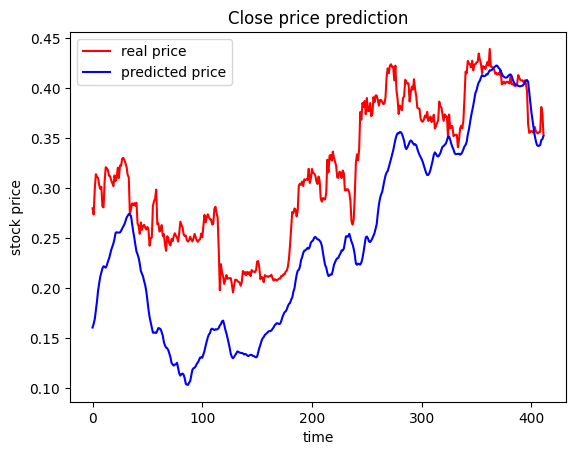

In [74]:
pred_y = model.predict(test_X)

plt.figure()
plt.plot(test_y, color='red', label='real price')
plt.plot(pred_y, color='blue', label='predicted price')
plt.title('Close price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()
